#### Import packages and device selection

In [1]:
import gc
import os
import re
from collections import deque
import cv2
import lmdb
import pickle
import shutil
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState
import torch
from torch import nn, optim
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.models as models
from torchinfo import summary
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 224
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(seed)
torch.manual_seed(seed) # if using CPU
torch.cuda.manual_seed(seed) # if using single-GPU
torch.cuda.manual_seed_all(seed) # if using multi-GPU
torch.backends.cudnn.deterministic = True # deterministic mode
torch.backends.cudnn.benchmark = False # disable auto-tuner to find the best algorithm to use for your hardware
torch.backends.cuda.matmul.allow_tf32 = True # allow TensorFloat-32 on matmul operations
torch.backends.cudnn.allow_tf32  = True # allow TensorFloat-32 on convolution operations
torch.autograd.set_detect_anomaly(True)

In [3]:
print("Using device: ", device)

Using device:  cuda


## Dataset Loading and Preprocessing

#### This is used only to visualize some samples from the dataset

In [4]:
def sort_files(folder):
    convert_func = lambda x: int(x) if x.isdigit() else x.lower()
    key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
    return sorted(folder, key=key_func)

input_L = []
target_ab = []
path = '../data/color'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder, desc='Loading color images'):
    img = cv2.imread(os.path.join(path, file), 1)
    img = img.astype(np.float32) / 255.0 # [0, 1]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img = cv2.resize(img, (SIZE, SIZE))
    L = img[:, :, 0:1] # (H, W, 1) [0, 100]
    ab = img[:, :, 1:3] # (H, W, 2) [-128, 127]
    input_L.append(L)
    target_ab.append(ab)
input_L = np.array(input_L) # (N, H, W, 1)
target_ab = np.array(target_ab) # (N, H, W, 2

Loading color images:   0%|          | 0/7129 [00:00<?, ?it/s]

In [5]:
print(input_L.shape, target_ab.shape)

(7129, 224, 224, 1) (7129, 224, 224, 2)


#### Display some samples

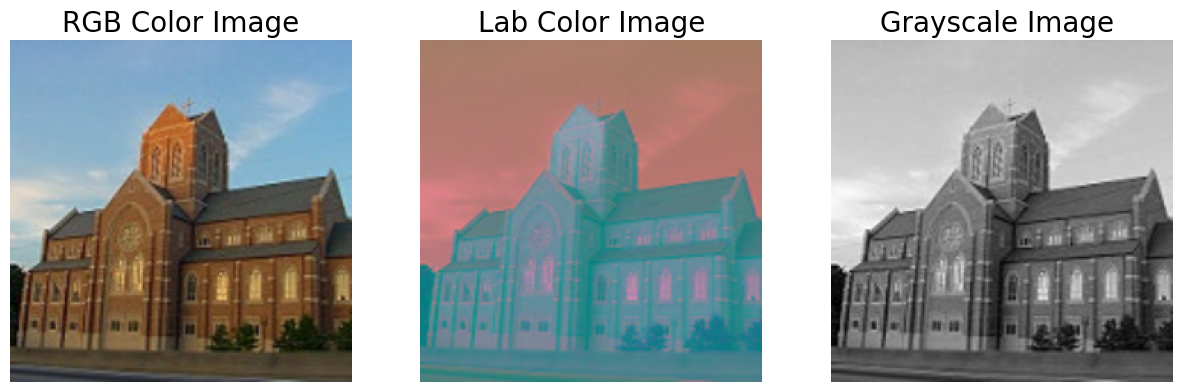

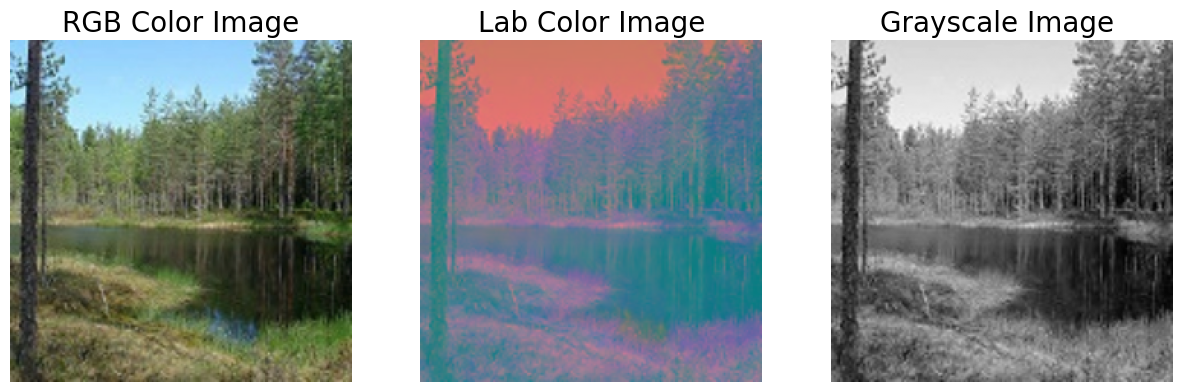

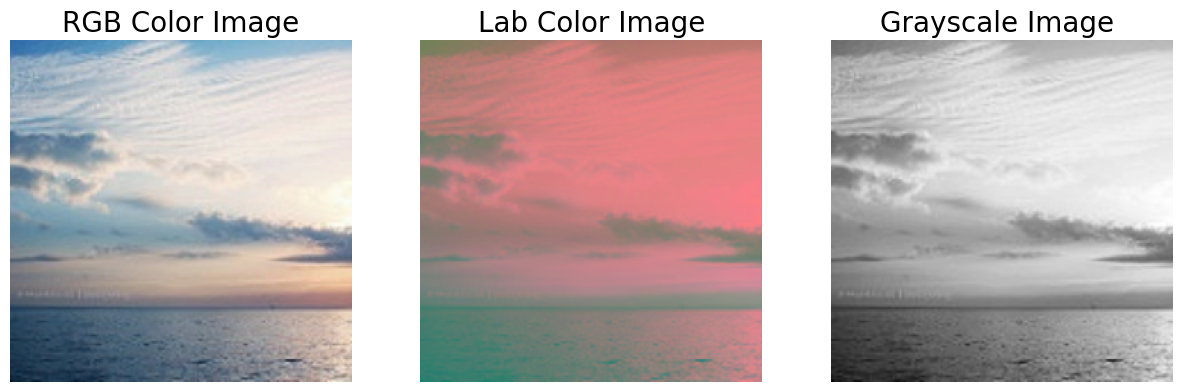

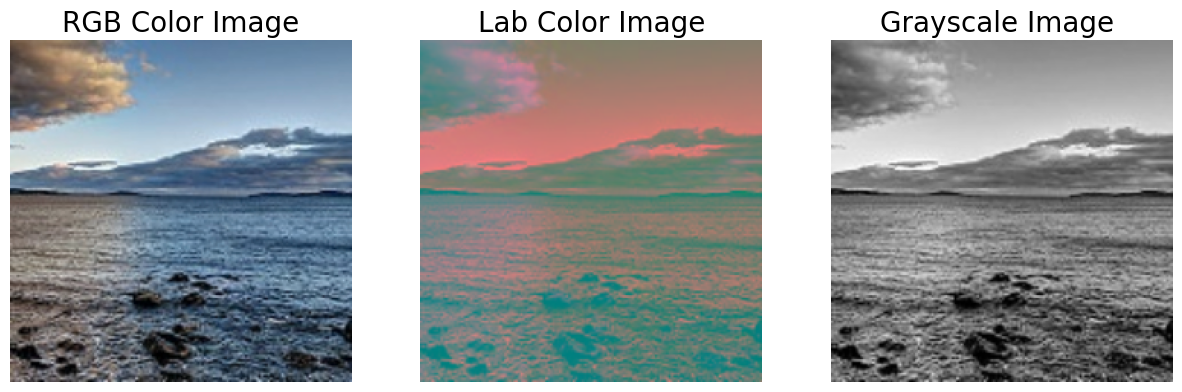

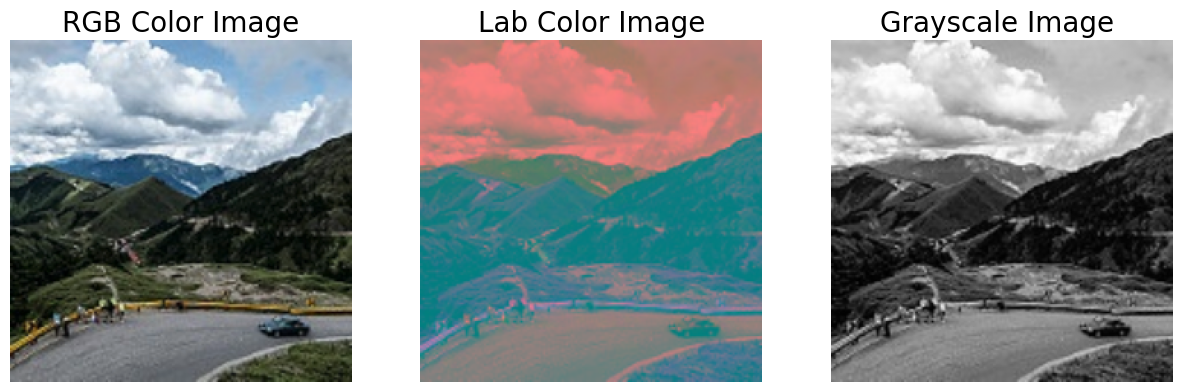

In [6]:
for _ in range(5):
    idx = np.random.randint(0, len(input_L) - 1)
    color_img = np.concatenate([input_L[idx] / 100 * 255, target_ab[idx] + 128], axis=2).clip(0, 255).astype(np.uint8)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('RGB Color Image', fontsize=20)
    plt.imshow(np.clip(cv2.cvtColor(color_img, cv2.COLOR_LAB2RGB), 0, 255))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Lab Color Image', fontsize=20)
    plt.imshow(color_img)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Grayscale Image ', fontsize=20)
    plt.imshow((input_L[idx] / 100 * 255).astype(np.uint8).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

#### Split into training and test data

We can use the entire dataset, instead of the file path, as it is small enough to fit in memory

In [7]:
input_L = (torch.from_numpy(input_L) / 100.0).permute(0, 3, 1, 2) # (N, 1, H, W) [0, 1]
target_ab = torch.from_numpy(target_ab).permute(0, 3, 1, 2) # (N, 2, H, W) [-128, 127]
L_train, L_test, ab_train, ab_test = train_test_split(input_L, target_ab, test_size=0.2, random_state=seed)
L_val, L_test, ab_val, ab_test = train_test_split(L_test, ab_test, test_size=0.2, random_state=seed)

In [8]:
print(L_train.shape, ab_train.shape)
print(L_val.shape, ab_val.shape)
print(L_test.shape, ab_test.shape)

torch.Size([5703, 1, 224, 224]) torch.Size([5703, 2, 224, 224])
torch.Size([1140, 1, 224, 224]) torch.Size([1140, 2, 224, 224])
torch.Size([286, 1, 224, 224]) torch.Size([286, 2, 224, 224])


In [9]:
L_mean = torch.mean(L_train, dim=[0, 2, 3])
L_std = torch.std(L_train, dim=[0, 2, 3])

In [10]:
print(L_mean, L_std)

tensor([0.4731]) tensor([0.2583])


In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, L_data, ab_data, L_transform=None):
        self.L_data = L_transform(L_data) if L_transform else L_data
        self.ab_data = ab_data

    def __len__(self):
        return len(self.L_data)

    def __getitem__(self, idx):
        return self.L_data[idx], self.ab_data[idx]

class DatasetWithFeatures(torch.utils.data.Dataset):
    def __init__(self, og_dataset, lmdb_path):
        self.og_dataset = og_dataset
        self.lmdb_path = lmdb_path
        self.env = None
        self.txn = None

    def __len__(self):
        return len(self.og_dataset)

    def __getitem__(self, idx):
        if self.env is None:
            self.env = lmdb.open(self.lmdb_path, readonly=True, lock=False, readahead=False)
            self.txn = self.env.begin()
        L, ab_target = self.og_dataset[idx]
        feature_serialized = self.txn.get(f"{idx}".encode())
        metadata_len = int.from_bytes(feature_serialized[:4], 'little')
        metadata = pickle.loads(feature_serialized[4:4 + metadata_len])
        shapes = metadata["shapes"]
        dtypes = metadata["dtypes"]
        data_bytes = feature_serialized[4 + metadata_len:]
        target_features = []
        current_offset = 0
        for shape, dtype in zip(shapes, dtypes):
            num_bytes = np.prod(shape) * np.dtype(dtype).itemsize
            arr = np.frombuffer(data_bytes, dtype=dtype, count=np.prod(shape), offset=current_offset).reshape(shape)
            target_features.append(arr)
            current_offset +=num_bytes
            # without copy() it is read-only
        return L, ab_target, [torch.from_numpy(arr.copy()) for arr in target_features]

    def __del__(self):
        if self.env is not None:
            self.env.close()
            self.env = None

In [12]:
class CUDAPrefetcher:
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = None
        if torch.cuda.is_available():
            self.stream = torch.cuda.Stream()
        self.next_L = None
        self.next_ab = None
        self._preload()

    def _preload(self):
        try:
            self.next_L, self.next_ab = next(self.loader)
        except StopIteration:
            self.next_L = None
            self.next_ab = None
            return
        if self.stream: # Check if a CUDA stream exists
            with torch.cuda.stream(self.stream):
                self.next_L = self.next_L.to(device, memory_format=torch.channels_last, non_blocking=True)
                self.next_ab = self.next_ab.to(device, memory_format=torch.channels_last, non_blocking=True)
        # If no stream, the data remains on the CPU, which is fine for CPU-only runs

    def next(self):
        if self.stream: # Wait for the stream only if it exists
            torch.cuda.current_stream().wait_stream(self.stream)
        L, ab = self.next_L, self.next_ab
        self._preload()
        return L, ab

class CUDAPrefetcherWithFeatures:
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = None
        if torch.cuda.is_available():
            self.stream = torch.cuda.Stream()
        self.next_L = None
        self.next_ab = None
        self.next_features = None
        self._preload()

    def _preload(self):
        try:
            self.next_L, self.next_ab, self.next_features = next(self.loader)
        except StopIteration:
            self.next_L = None
            self.next_ab = None
            self.next_features = None
            return
        if self.stream: # Check if a CUDA stream exists
            with torch.cuda.stream(self.stream):
                self.next_L = self.next_L.to(device, memory_format=torch.channels_last, non_blocking=True)
                self.next_ab = self.next_ab.to(device, memory_format=torch.channels_last, non_blocking=True)
                self.next_features = [f.to(device, non_blocking=True) for f in self.next_features]
        # If no stream, the data remains on the CPU, which is fine for CPU-only runs

    def next(self):
        if self.stream: # Wait for the stream only if it exists
            torch.cuda.current_stream().wait_stream(self.stream)
        L, ab, features = self.next_L, self.next_ab, self.next_features
        self._preload()
        return L, ab, features

In [13]:
trainset = MyDataset(L_train, ab_train, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
valset = MyDataset(L_val, ab_val, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
testset = MyDataset(L_test, ab_test, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
L_mean = L_mean.reshape(1, -1, 1, 1).to(device, memory_format=torch.channels_last, non_blocking=True)
L_std = L_std.reshape(1, -1, 1, 1).to(device, memory_format=torch.channels_last, non_blocking=True)
del L_train, ab_train, L_val, ab_val, L_test, ab_test

## Training pipeline

#### Early stopping used to stop training if model begins to overfit

In [14]:
def save_checkpoint(model, name='checkpoint'):
    torch.save(model.state_dict(), f"../models/{name}.pth")

class EarlyStopping:
    def __init__(self, patience=10, delta=0.05):
        self.patience = patience
        self.counter = 0
        self.best_score = np.Inf
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, net):
        if self.best_score > val_loss:
            self.best_score = val_loss
            self.counter = 0
            save_checkpoint(net)
        elif self.best_score + self.delta < val_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

#### Check VGG19 architecture to select layers for perceptual loss

In [15]:
print(models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [16]:
class VGGLoss(nn.Module):
    def __init__(self, layers):
        super(VGGLoss, self).__init__()
        blocks = []
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        for i in range(len(layers)-1):
            blocks.append(nn.Sequential(*list(vgg.children())[layers[i]:layers[i+1]]))
        self.blocks = nn.ModuleList(blocks)
        for block in self.blocks:
            block.eval()
            for p in block.parameters():
                p.requires_grad = False
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1))

    def _lab_to_rgb(self, L, ab):
        lab = torch.cat([L, ab], dim=1)  # (B,3,H,W)
        # convert to XYZ
        Y = (lab[:, 0:1, :, :] + 16.0) / 116.0
        X = lab[:, 1:2, :, :] / 500.0 + Y
        Z = Y - lab[:, 2:3, :, :] / 200.0
        # apply f^-1 (piecewise)
        eps = 0.008856
        xyz = torch.cat([X, Y, Z], dim=1)
        xyz = torch.where(xyz > 0.008856, xyz ** 3, (xyz - 16.0 / 116.0) / 7.787)
        # Apply D65 whitepoint scaling
        xyz = xyz.clone()
        xyz[:, 0:1, :, :] = xyz[:, 0:1, :, :] * 0.95047
        xyz[:, 2:3, :, :] = xyz[:, 2:3, :, :] * 1.08883
        rgb = torch.zeros_like(xyz)
        rgb[:, 0:1, :, :] = (xyz[:, 0:1, :, :] * 3.2406 + xyz[:, 1:2, :, :] * (-1.5372) + xyz[:, 2:3, :, :] * (-0.4986))
        rgb[:, 1:2, :, :] = (xyz[:, 0:1, :, :] * (-0.9689) + xyz[:, 1:2, :, :] * 1.8758 + xyz[:, 2:3, :, :] * 0.0415)
        rgb[:, 2:3, :, :] = (xyz[:, 0:1, :, :] * 0.0557 - xyz[:, 1:2, :, :] * (-0.2040) + xyz[:, 2:3, :, :] * 1.0570)
        # gamma correction
        rgb = torch.where(rgb > 0.0031308, 1.055 * (torch.relu(rgb) ** (1 * 2.4)) - 0.055, 12.92 * rgb)
        rgb = torch.clamp(rgb, 0.0, 1.0) # (B, 3, H, W)
        return rgb

    def forward(self, L, ab_pred, ab_target):
        L = L
        pred_rgb = (self._lab_to_rgb(L, ab_pred) - self.mean) / self.std
        target_rgb = (self._lab_to_rgb(L, ab_target) - self.mean) / self.std
        loss = torch.tensor(0.0, device=device)
        x = pred_rgb
        y = target_rgb
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += nn.functional.l1_loss(x, y)
        return loss

class VGGLossWithFeatures(nn.Module):
    def __init__(self, layers):
        super(VGGLossWithFeatures, self).__init__()
        blocks = []
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        for i in range(len(layers)-1):
            blocks.append(nn.Sequential(*list(vgg.children())[layers[i]:layers[i+1]]))
        self.blocks = nn.ModuleList(blocks)
        for block in self.blocks:
            block.eval()
            for p in block.parameters():
                p.requires_grad = False
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1))

    def _lab_to_rgb(self, L, ab):
        lab = torch.cat([L, ab], dim=1)  # (B,3,H,W)
        # convert to XYZ
        Y = (lab[:, 0:1, :, :] + 16.0) / 116.0
        X = lab[:, 1:2, :, :] / 500.0 + Y
        Z = Y - lab[:, 2:3, :, :] / 200.0
        # apply f^-1 (piecewise)
        eps = 0.008856
        xyz = torch.cat([X, Y, Z], dim=1)
        xyz = torch.where(xyz > 0.008856, xyz ** 3, (xyz - 16.0 / 116.0) / 7.787)
        # Apply D65 whitepoint scaling
        xyz = xyz.clone()
        xyz[:, 0:1, :, :] = xyz[:, 0:1, :, :] * 0.95047
        xyz[:, 2:3, :, :] = xyz[:, 2:3, :, :] * 1.08883
        rgb = torch.zeros_like(xyz)
        rgb[:, 0:1, :, :] = (xyz[:, 0:1, :, :] * 3.2406 + xyz[:, 1:2, :, :] * (-1.5372) + xyz[:, 2:3, :, :] * (-0.4986))
        rgb[:, 1:2, :, :] = (xyz[:, 0:1, :, :] * (-0.9689) + xyz[:, 1:2, :, :] * 1.8758 + xyz[:, 2:3, :, :] * 0.0415)
        rgb[:, 2:3, :, :] = (xyz[:, 0:1, :, :] * 0.0557 - xyz[:, 1:2, :, :] * (-0.2040) + xyz[:, 2:3, :, :] * 1.0570)
        # gamma correction
        rgb = torch.where(rgb > 0.0031308, 1.055 * (torch.relu(rgb) ** (1 * 2.4)) - 0.055, 12.92 * rgb)
        rgb = torch.clamp(rgb, 0.0, 1.0) # (B, 3, H, W)
        return rgb

    @torch.no_grad()
    def extract_features(self, L , ab_target):
        self.eval()
        L = L
        target_rgb = (self._lab_to_rgb(L, ab_target) - self.mean) / self.std
        features = []
        y = target_rgb
        for block in self.blocks:
            y = block(y)
            features.append(y.detach().cpu())
        return features

    def forward(self, L, ab_pred, target_features):
        L = L
        pred_rgb = (self._lab_to_rgb(L, ab_pred) - self.mean) / self.std
        loss = torch.tensor(0.0, device=device)
        x = pred_rgb
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = target_features[i].to(device, non_blocking=True)
            loss += nn.functional.l1_loss(x, y)
        return loss

In [17]:
def fit(net, trainloader, optimizer, scaler, loss_vgg_fn, coeff_char, coeff_cos, coeff_vgg, coeff_kld):
    total_loss, total_sse, pixels, count = torch.tensor(0.0, device=device), torch.tensor(0.0, device=device), 0, 0
    net.train()
    prefetcher = CUDAPrefetcher(trainloader)
    # prefetcher = CUDAPrefetcherWithFeatures(trainloader)
    inputs, targets = prefetcher.next()
    # inputs, targets, targets_features = prefetcher.next()
    while inputs is not None:
        with torch.amp.autocast(device, dtype=torch.bfloat16):
            out, mu, logvar = net(inputs)
            out_rescaled = (out + 1.0) / 2.0 * 255.0 - 128.0  # rescale to [-128, 127]
            inputs = (inputs * L_std + L_mean) * 100.0
            loss_rec = torch.tensor(0.0, device=device)
            if coeff_char > 0.0:
                loss_rec += (lambda x, y: torch.mean(torch.sqrt((x - y) ** 2 + 1e-6 ** 2)))(out_rescaled, targets) * coeff_char
            if coeff_cos > 0.0:
                loss_rec += (1 - ((out_rescaled / (out_rescaled.norm(dim=1, keepdim=True) + 1e-8)) * (targets / (targets.norm(dim=1, keepdim=True) + 1e-6))).sum(dim=1)).mean() * coeff_cos
            if coeff_vgg > 0.0:
                loss_rec += loss_vgg_fn(inputs, out_rescaled, targets) * coeff_vgg
                # loss_rec += coeff_vgg * loss_vgg_fn(inputs, out, targets_features)
            loss_kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1).mean()
            loss = loss_rec + coeff_kld * loss_kld
        optimizer.zero_grad(set_to_none=True)
        if not torch.isfinite(loss):
            inputs, targets = prefetcher.next()
            # inputs, targets, targets_features = prefetcher.next()
            continue
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(net.parameters(), 3)
        scaler.step(optimizer)
        scaler.update()
        with torch.no_grad():
            total_loss += loss.detach()
            count += 1
            sse = nn.functional.mse_loss(out_rescaled, targets, reduction='sum')
            total_sse += sse
            pixels += targets.numel()
        inputs, targets = prefetcher.next()
        # inputs, targets, targets_features = prefetcher.next()
    mse = total_sse / pixels
    rmse = torch.sqrt(mse)
    psnr = 10 * torch.log10((255.0 ** 2) / (mse + 1e-8))
    return (total_loss / count).item(), rmse.item(), psnr.item()

@torch.no_grad()
def predict(net, valloader, loss_vgg_fn, coeff_char, coeff_cos, coeff_vgg, coeff_kld):
    total_loss, total_sse, pixels, count = torch.tensor(0.0, device=device), torch.tensor(0.0, device=device), 0, 0
    net.eval()
    prefetcher = CUDAPrefetcher(valloader)
    # prefetcher = CUDAPrefetcherWithFeatures(valloader)
    inputs, targets = prefetcher.next()
    # inputs, targets, targets_features = prefetcher.next()
    while inputs is not None:
        with torch.amp.autocast(device, dtype=torch.bfloat16):
            out, mu, logvar = net(inputs)
            out_rescaled = (out + 1.0) / 2.0 * 255.0 - 128.0  # rescale to [-128, 127]
            inputs = (inputs * L_std + L_mean) * 100.0
            loss_rec = torch.tensor(0.0, device=device)
            if coeff_char > 0.0:
                loss_rec += (lambda x, y: torch.mean(torch.sqrt((x - y) ** 2 + 1e-6 ** 2)))(out_rescaled, targets) * coeff_char
            if coeff_cos > 0.0:
                loss_rec += (1 - ((out_rescaled / (out_rescaled.norm(dim=1, keepdim=True) + 1e-8)) * (targets / (targets.norm(dim=1, keepdim=True) + 1e-6))).sum(dim=1)).mean() * coeff_cos
            if coeff_vgg > 0.0:
                loss_rec += loss_vgg_fn(inputs, out_rescaled, targets) * coeff_vgg
                # loss_rec += coeff_vgg * loss_vgg_fn(inputs, out, targets_features)
            loss_kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1).mean()
            loss = loss_rec + coeff_kld * loss_kld
        if not torch.isfinite(loss):
            inputs, targets = prefetcher.next()
            # inputs, targets, targets_features = prefetcher.next()
            continue
        total_loss += loss.detach()
        count += 1
        sse = nn.functional.mse_loss(out_rescaled, targets, reduction='sum')
        total_sse += sse
        pixels += targets.numel()
        inputs, targets = prefetcher.next()
        # inputs, targets, targets_features = prefetcher.next()
    mse = total_sse / pixels
    rmse = torch.sqrt(mse)
    psnr = 10 * torch.log10((255.0 ** 2) / (mse + 1e-8))
    return (total_loss / count).item(), rmse.item(), psnr.item()

#### Objective method for k fold cross validation

In [18]:
def objective(trial, trainset, scaler, X):
    num_epochs = 25
    num_cycles = trial.suggest_int('num_cycles', 4, 10)
    cycle_length = num_epochs // num_cycles
    final_coeff_kld = trial.suggest_float('final_coeff_kld', 0.1, 1.0, log=True)
    coeff_char = trial.suggest_float('coeff_char', 0.1, 1.0, log=True)
    coeff_cos = trial.suggest_float('coeff_cos', 0.1, 1.0, log=True)
    coeff_vgg = trial.suggest_float('coeff_vgg', 0.1, 1.0, log=True)
    layers = trial.suggest_categorical('layers', [[0, 17], [0, 26], [0, 17, 26]])
    lr = trial.suggest_float('lr', 1e-6, 5e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    latent_dim = trial.suggest_categorical('latent_dim', [64, 128, 256, 512])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses, split_n = [], 0
    prog_bar = tqdm(kf.split(X), desc="Splits", total=5, position=0)
    for train_idx, val_idx in prog_bar:
        gc.collect()
        torch.cuda.empty_cache()
        split_n += 1
        trainloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx), num_workers=4, pin_memory=True)
        valloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx), num_workers=4, pin_memory=True)
        loss_vgg_fn = VGGLoss(layers).to(device)
        net = Net(latent_dim).to(device)
        optimizer = optim.AdamW(net.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
        val_losses = deque(maxlen=3)
        for epoch in range(num_epochs):
            gc.collect()
            torch.cuda.empty_cache()
            cycle_pos = epoch % cycle_length
            coeff_kld = final_coeff_kld * (0.5 * (1 + np.cos(np.pi * (1 - cycle_pos / cycle_length))))
            train_loss, train_rmse, train_psnr = fit(net, trainloader, optimizer, scaler, loss_vgg_fn, coeff_char, coeff_cos, coeff_vgg, coeff_kld)
            val_loss, val_rmse, val_psnr = predict(net, valloader, loss_vgg_fn, coeff_char, coeff_cos, coeff_vgg, coeff_kld)
            # scheduler.step(val_psnr)
            val_losses.append(val_loss)
            current_lr = optimizer.param_groups[0]['lr']
            prog_bar.set_description(f"Epoch {epoch + 1}, lr={current_lr}, coeff_kld={coeff_kld:.3f}, Loss={train_loss:.3f}/{val_loss:.3f} | Metrics train/val: RMSE={train_rmse:.3f}/{val_rmse:.3f}, PSNR={train_psnr:.3f}/{val_psnr:.3f}")
        del net, optimizer, scheduler
        fold_mean_loss = np.mean(val_losses)
        fold_losses.append(fold_mean_loss)
        trial.report(fold_mean_loss, split_n)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return np.mean(fold_losses)

#### CAE NN definition

out = (in - kernel + 2 * pad) / stride + 1

In [19]:
class Net(nn.Module):
    def __init__(self, latent_dim=256):
        super(Net, self).__init__()
        self.latent_dim = latent_dim
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        ) # [B, 64, size/2, size/2]
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        ) # [B, 128, size/4, size/4]
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc_mu_logvar = nn.Conv2d(256, 2 * latent_dim, kernel_size=1)
        self.decoder_input = nn.Linear(latent_dim, 256 * (SIZE // 8) * (SIZE // 8))
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128 + 128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        e1 = self.enc1(x) # [B, 64, size/2, size/2]
        e2 = self.enc2(e1) # [B, 128, size/4, size/4]
        e3 = self.enc3(e2) # [B, 256, size/8, size/8]
        e4 = self.enc4(e3) # [B, 256, size/8, size/8]
        pooled = self.pool(e4)  # [B, 256, 1, 1]
        pooled = self.dropout(pooled)
        mu_logvar = self.fc_mu_logvar(pooled).squeeze(-1).squeeze(-1)  # [B, 2*latent_dim]
        mu, logvar = mu_logvar.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        dec_input = self.decoder_input(z)
        d = dec_input.reshape(-1, 256, SIZE // 8, SIZE // 8)
        d1 = self.dec1(d) # [B, 128, size/4, size/4]
        d1 = torch.cat([d1, e2], dim=1)
        d2 = self.dec2(d1) # [B, 64, size/2, size/2]
        d2 = torch.cat([d2, e1], dim=1)
        d3 = self.dec3(d2) # [B, 32, size/2, size/2]
        out = self.dec4(d3) # [B, 2, size, size]

        return out, mu, logvar

In [20]:
writer = SummaryWriter('../runs')
net = Net(latent_dim=64).eval()
# torch.quantization.fuse_modules(net, [
#     ['conv3', 'bnorm1'],
#     ['conv4', 'bnorm2'],
#     ['conv5', 'bnorm3']
# ], inplace=True)
net = net.to(device, memory_format=torch.channels_last)
for m in net.modules():
    if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
        m.weight = torch.nn.Parameter(m.weight.to(memory_format=torch.channels_last))
dummy = torch.zeros(1, 1, SIZE, SIZE).to(device, memory_format=torch.channels_last)
writer.add_graph(net, dummy)
writer.flush()
summary(net, input_data=dummy, col_names=('input_size', 'output_size', 'num_params', 'trainable'))

/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/jit/_trace.py:1310: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(1, 64, strides=[64, 1], requires_grad=0, device=cuda:0) = aten::randn_like(%std, %384, %385, %386, %387, %388) # /tmp/ipykernel_339873/1130437787.py:57:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/jit/_trace.py:1310: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 100239 / 100352 (99.9%)
Greatest absolute difference: 0.04951850511133671 at index (0, 1, 155, 67) (up to 1e-05 allowed)
Greatest relative difference: 17836.598039215685 at index (0, 1, 20, 54) (up to 1e-05 allowed)
  _check_trace(


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Net                                      [1, 1, 224, 224]          [1, 2, 224, 224]          --                        True
├─Sequential: 1-1                        [1, 1, 224, 224]          [1, 64, 112, 112]         --                        True
│    └─Conv2d: 2-1                       [1, 1, 224, 224]          [1, 64, 112, 112]         640                       True
│    └─LeakyReLU: 2-2                    [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
├─Sequential: 1-2                        [1, 64, 112, 112]         [1, 128, 56, 56]          --                        True
│    └─Conv2d: 2-3                       [1, 64, 112, 112]         [1, 128, 112, 112]        73,856                    True
│    └─LeakyReLU: 2-4                    [1, 128, 112, 112]        [1, 128, 112, 112]        --                        --
│    └─

In [21]:
del dummy

Run command:\
tensorboard --logdir=runs\
Visible at http://localhost:6006/

### Hyper parameter tuning

In [22]:
# gc.collect()
# torch.cuda.empty_cache()
# X = np.zeros(len(trainset))
# scaler = torch.amp.GradScaler(device)
# study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
# study.optimize(lambda trial: objective(trial, trainset, scaler, X), n_trials=5)

[I 2025-09-17 14:43:27,949] A new study created in memory with name: no-name-0b7dc92c-d4a0-4f71-a9d7-8f9cb6301255
/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [0, 17] which is of type list.
  warnings.warn(message)
/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [0, 26] which is of type list.
  warnings.warn(message)
/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [0, 17, 26] which is of type list.
  warnings.warn(message)


Splits: 0it [00:00, ?it/s]

[I 2025-09-17 16:15:54,941] Trial 0 finished with value: 7.519392267862957 and parameters: {'num_cycles': 7, 'final_coeff_kld': 0.364991764995791, 'coeff_char': 0.23378777876152895, 'coeff_cos': 0.46841124860557454, 'coeff_vgg': 0.1492472606053495, 'layers': [0, 26], 'lr': 1.930515706142354e-06, 'batch_size': 32, 'latent_dim': 256}. Best is trial 0 with value: 7.519392267862957.


Splits: 0it [00:00, ?it/s]

[I 2025-09-17 17:45:24,011] Trial 1 finished with value: 9.222521050771077 and parameters: {'num_cycles': 7, 'final_coeff_kld': 0.1677769112972082, 'coeff_char': 0.11716967113227192, 'coeff_cos': 0.6526418028509098, 'coeff_vgg': 0.12202455042410497, 'layers': [0, 26], 'lr': 0.00015923804333260963, 'batch_size': 32, 'latent_dim': 64}. Best is trial 0 with value: 7.519392267862957.


Splits: 0it [00:00, ?it/s]

[I 2025-09-17 19:07:59,883] Trial 2 finished with value: 26.999989191691082 and parameters: {'num_cycles': 9, 'final_coeff_kld': 0.2925158893495361, 'coeff_char': 0.621772322924373, 'coeff_cos': 0.11812747731695951, 'coeff_vgg': 0.6490945583890618, 'layers': [0, 26], 'lr': 0.00019685677025797828, 'batch_size': 64, 'latent_dim': 512}. Best is trial 0 with value: 7.519392267862957.


Splits: 0it [00:00, ?it/s]

[I 2025-09-17 20:21:55,935] Trial 3 finished with value: 4.742728646596272 and parameters: {'num_cycles': 8, 'final_coeff_kld': 0.3952161534971111, 'coeff_char': 0.1302382224558998, 'coeff_cos': 0.16202270458858067, 'coeff_vgg': 0.3049291459137929, 'layers': [0, 17], 'lr': 1.1052640500598283e-06, 'batch_size': 64, 'latent_dim': 512}. Best is trial 3 with value: 4.742728646596272.


Splits: 0it [00:00, ?it/s]

[I 2025-09-17 21:52:21,448] Trial 4 finished with value: 12.191290537516277 and parameters: {'num_cycles': 8, 'final_coeff_kld': 0.4174986522453939, 'coeff_char': 0.26009166450231674, 'coeff_cos': 0.10518515004555831, 'coeff_vgg': 0.9718017433467012, 'layers': [0, 17, 26], 'lr': 2.639646045389176e-06, 'batch_size': 32, 'latent_dim': 64}. Best is trial 3 with value: 4.742728646596272.


In [23]:
# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
#
# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))
#
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  4.742728646596272
  Params: 
    num_cycles: 8
    final_coeff_kld: 0.3952161534971111
    coeff_char: 0.1302382224558998
    coeff_cos: 0.16202270458858067
    coeff_vgg: 0.3049291459137929
    layers: [0, 17]
    lr: 1.1052640500598283e-06
    batch_size: 64
    latent_dim: 512


### Entire dataset

In [ ]:
layers = [0, 17, 26]

#### Precompute VGG features for the entire dataset and save to disk

In [ ]:
# @torch.no_grad()
# def create_features_file(vgg, out_dir, dataset):
#     lmdb_path = os.path.join(out_dir, "features.lmdb")
#     if os.path.exists(lmdb_path):
#         shutil.rmtree(lmdb_path)
#     env = None
#     try:
#         env = lmdb.open(lmdb_path, map_size=800000000000) # ~700GB
#         dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
#         idx = 0
#         BATCHES_PER_TRANSACTION = 15
#         txn = env.begin(write=True)  # Start the very first transaction here
#         for batch_idx, (L_batch, ab_batch) in enumerate(tqdm(dataloader, desc="Extracting features to LMDB")):
#             # Check if it's time to commit and start a new transaction
#             if batch_idx > 0 and batch_idx % BATCHES_PER_TRANSACTION == 0:
#                 txn.commit()
#                 txn = env.begin(write=True)
#             L_batch = (L_batch.to(device, memory_format=torch.channels_last,non_blocking=True) * L_std + L_mean) * 100.0
#             ab_batch = ab_batch.to(device, memory_format=torch.channels_last, non_blocking=True)
#             feature_batch = vgg.extract_features(L_batch, ab_batch)
#             bs = L_batch.size(0)
#             for i in range(bs):
#                 single_features = [f[i].numpy() for f in feature_batch]
#                 metadata = {
#                     'shapes': [arr.shape for arr in single_features],
#                     'dtypes': [str(arr.dtype) for arr in single_features]
#                 }
#                 metadata_bytes = pickle.dumps(metadata)
#                 data_bytes = b''.join([arr.tobytes() for arr in single_features])
#                 metadata_len = len(metadata_bytes)
#                 feature_serialized = metadata_len.to_bytes(4, 'little') + metadata_bytes + data_bytes
#                 txn.put(f"{idx}".encode(), feature_serialized)
#                 idx += 1
#         # Final commit to ensure all remaining changes are saved
#         txn.commit()
#     finally:
#         if env is not None:
#             env.close()

Uncomment to recreate the feature maps files

In [ ]:
# vgg_extractor = VGGLossWithFeatures(layers).to(device).eval()
# out_dir = '../data/features/train'
# os.makedirs(out_dir, exist_ok=True)
# create_features_file(vgg_extractor, out_dir, trainset)
# out_dir = '../data/features/validation'
# os.makedirs(out_dir, exist_ok=True)
# create_features_file(vgg_extractor, out_dir, valset)
# out_dir = '../data/features/test'
# os.makedirs(out_dir, exist_ok=True)
# create_features_file(vgg_extractor, out_dir, testset)

In [ ]:
# trainset = DatasetWithFeatures(trainset, '../data/features/train/features.lmdb')
# valset = DatasetWithFeatures(valset, '../data/features/validation/features.lmdb')
# testset = DatasetWithFeatures(testset, '../data/features/test/features.lmdb')

In [ ]:
print(len(trainset))
print(trainset[0][0].shape)
print(trainset[0][1].shape)
# print(len(trainset[0][2]))
# for i, f in enumerate(trainset[0][2]):
#     print(f"Block {i} shape: {f.shape}")

#### Unit test: graident flow check

In [ ]:
def test_grad_flow(test_net):
    test_net.train()
    scaler = torch.amp.GradScaler(device)
    # with shuffle True it takes a bit longer
    loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
    print('prefetcher pre')
    prefetcher = CUDAPrefetcher(loader)
    # prefetcher = CUDAPrefetcherWithFeatures(loader)
    print('prefetcher post')
    optimizer = optim.AdamW(test_net.parameters(), lr=1e-4)
    criterion2 = VGGLoss(layers).to(device)
    # criterion2 = VGGLossWithFeatures(layers).to(device)
    num_batches = len(loader)
    pbar = tqdm(total=num_batches, desc="Prefetching")
    print('prefetcher next pre')
    inputs, targets = prefetcher.next()
    # inputs, targets, features = prefetcher.next()
    print('prefetcher next post')
    with torch.amp.autocast(device, dtype=torch.bfloat16):
        out, mu, logvar = test_net(inputs)
        out_rescaled = (out + 1.0) / 2.0 * 255.0 - 128.0  # rescale to [-128, 127]
        inputs = (inputs * L_std + L_mean) * 100.0
        loss_pix = (lambda x, y: torch.mean(torch.sqrt((x - y) ** 2 + 1e-6 ** 2)))(out_rescaled, targets) * 1.0
        print(f"Pixel loss: {loss_pix.item():.4f}")
        loss_cos = (1 - ((out_rescaled / (out_rescaled.norm(dim=1, keepdim=True) + 1e-8)) * (targets / (targets.norm(dim=1, keepdim=True) + 1e-6))).sum(dim=1)).mean() * 0.5
        print(f"Cosine loss: {loss_cos.item():.4f}")
        loss_vgg = criterion2(inputs, out_rescaled, targets) * 1.0
        # loss_vgg = criterion2(inputs, out_rescaled, features) * 1.0
        print(f"VGG loss: {loss_vgg.item():.4f}")
        loss_kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1).mean() * 0.2
        print(f"KLD loss: {loss_kld.item():.4f}")
        loss = loss_pix + loss_cos + loss_vgg + loss_kld
        print(f"Total loss: {loss.item():.4f}")
    optimizer.zero_grad(set_to_none=True)
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    nn.utils.clip_grad_norm_(test_net.parameters(), 3)
    scaler.step(optimizer)
    scaler.update()
    pbar.update(1)
    print('prefetcher next pre')
    inputs, targets = prefetcher.next()
    # inputs, targets, features = prefetcher.next()
    print('prefetcher next post')
    net_has_grad = False
    for p in test_net.parameters():
        if p.grad is not None:
            if float(p.grad.abs().sum()) > 0.0:
                net_has_grad = True
                break
    vgg_params_ok = True
    for name, p in criterion2.named_parameters():
        if p.requires_grad:
            print(f"VGGLoss parameter {name} has requires_grad=True (should be False).")
            vgg_params_ok = False
        if p.grad is not None:
            # Ideally grads are None for frozen params
            print(f"VGGLoss parameter {name} has non-None grad (should be None).")
            vgg_params_ok = False
    print(f"Net received gradient? {net_has_grad}")
    print(f"VGGLoss params frozen and no grads? {vgg_params_ok}")
    pbar.close()
    return net_has_grad, vgg_params_ok

test_net = Net().to(device)
ok_net, ok_vgg = test_grad_flow(test_net)
assert ok_net and ok_vgg, "Unit test failed: check gradients or VGGLoss freezing"

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def test_fit(test_net):
    coeff_char = 1.0
    coeff_cos = 0.1
    coeff_vgg = 1.0
    coeff_kld = 0.2
    total_loss, total_sse, pixels, count = torch.tensor(0.0, device=device), torch.tensor(0.0, device=device), 0, 0
    optimizer = optim.AdamW(test_net.parameters(), lr=1e-4, fused=True)
    loss_vgg_fn = VGGLoss(layers).to(device)
    # loss_vgg_fn = VGGLossWithFeatures(layers).to(device)
    test_net.train()
    scaler = torch.amp.GradScaler(device)
    loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
    prefetcher = CUDAPrefetcher(loader)
    # prefetcher = CUDAPrefetcherWithFeatures(loader)
    num_batches = len(loader)
    pbar = tqdm(total=num_batches, desc="Prefetching")
    inputs, targets = prefetcher.next()
    # inputs, targets, targets_features = prefetcher.next()
    while inputs is not None:
        with torch.amp.autocast(device, dtype=torch.bfloat16):
            out, mu, logvar = test_net(inputs)
            out_rescaled = (out + 1.0) / 2.0 * 255.0 - 128.0  # rescale to [-128, 127]
            inputs = (inputs * L_std + L_mean) * 100.0
            loss_rec = torch.tensor(0.0, device=device)
            if coeff_char > 0.0:
                loss_rec += (lambda x, y: torch.mean(torch.sqrt((x - y) ** 2 + 1e-6 ** 2)))(out_rescaled, targets) * coeff_char
            if coeff_cos > 0.0:
                loss_rec += (1 - ((out_rescaled / (out_rescaled.norm(dim=1, keepdim=True) + 1e-8)) * (targets / (targets.norm(dim=1, keepdim=True) + 1e-6))).sum(dim=1)).mean() * coeff_cos
            if coeff_vgg > 0.0:
                loss_rec += loss_vgg_fn(inputs, out_rescaled, targets) * coeff_vgg
                # loss_rec += coeff_vgg * loss_vgg_fn(inputs, out, targets_features)
            loss_kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1).mean()
            loss = loss_rec + coeff_kld * loss_kld
        optimizer.zero_grad(set_to_none=True)
        if not torch.isfinite(loss):
            inputs, targets = prefetcher.next()
            # inputs, targets, targets_features = prefetcher.next()
            continue
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(test_net.parameters(), 3)
        scaler.step(optimizer)
        scaler.update()
        with torch.no_grad():
            total_loss += loss.detach()
            count += 1
            sse = nn.functional.mse_loss(out_rescaled, targets, reduction='sum')
            total_sse += sse
            pixels += targets.numel()
        pbar.set_postfix({'loss': (total_loss / count).item()})
        pbar.update(1)
        inputs, targets = prefetcher.next()
        # inputs, targets, targets_features = prefetcher.next()
    pbar.close()
    mse = total_sse / pixels
    rmse = torch.sqrt(mse)
    psnr = 10 * torch.log10((255.0 ** 2) / (mse + 1e-8))
    return (total_loss / count).item(), rmse.item(), psnr.item()

test_net = Net().to(device)
test_loss, test_rmse, test_psnr = test_fit(test_net)
print(f"Total loss: {test_loss:.4f}, Total rmse: {test_rmse:.4f}, Total psnr: {test_psnr:.4f}")

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
optimizer = optim.AdamW(net.parameters(), lr=1e-4, fused=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
loss_vgg_fn = VGGLoss(layers).to(device)
early_stopping = EarlyStopping()
train_losses, train_rmses, train_psnrs = [], [], []
val_losses, val_rmses, val_psnrs = [], [], []
last_checkpoint = None
num_epochs = 50
num_cycles = 4
cycle_length = num_epochs // num_cycles
final_coeff_kld = 0.5
coeff_char = 1.0
coeff_cos = 0.05
coeff_vgg = 1.0

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
%matplotlib notebook
def update_plot():
    line1.set_data(range(len(train_losses)), train_losses)
    line2.set_data(range(len(val_losses)), val_losses)
    ax.set_yscale('log')
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()

In [ ]:
prog_bar = tqdm(range(num_epochs), total=num_epochs, desc='Training', position=0)

fig, ax = plt.subplots()
line1, = ax.plot([], [], label='Train Loss')
line2, = ax.plot([], [], label='Val Loss')
ax.legend()

scaler = torch.amp.GradScaler(device)
for epoch in prog_bar:
    gc.collect()
    torch.cuda.empty_cache()
    cycle_pos = epoch % cycle_length
    coeff_kld = final_coeff_kld * (0.5 * (1 + np.cos(np.pi * (1 - cycle_pos / cycle_length))))
    train_loss, train_rmse, train_psnr = fit(net, trainloader, optimizer, scaler,loss_vgg_fn, coeff_char, coeff_cos, coeff_vgg, coeff_kld)
    train_losses.append(train_loss)
    train_rmses.append(train_rmse)
    train_psnrs.append(train_psnr)
    val_loss, val_rmse, val_psnr = predict(net, valloader, loss_vgg_fn, coeff_char, coeff_cos, coeff_vgg, coeff_kld)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    val_psnrs.append(val_psnr)
    #scheduler.step(val_psnr)
    #early_stopping(val_loss, net)
    current_lr = optimizer.param_groups[0]['lr']
    prog_bar.set_description(f"Epoch {epoch + 1}, lr={current_lr}, coeff_kld={coeff_kld:.3f}, Loss={train_loss:.3f}/{val_loss:.3f} | "
                             f"Metrics train/val: RMSE={train_rmse:.3f}/{val_rmse:.3f}, PSNR={train_psnr:.3f}/{val_psnr:.3f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    update_plot()
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break
save_checkpoint(net, 'lastcheck')
writer.flush()

In [ ]:
%matplotlib inline
class ModelWithLoss(nn.Module):
    def __init__(self, net, loss_fn):
        super().__init__()
        self.net = net
        self.loss_fn = loss_fn

    def forward(self, x, y):
        preds = self.net(x)
        return self.loss_fn(preds, y)

## Evaluate results

To use NN:
rt = torch.jit.load("model_and_loss.pt")\
rt.eval()\
out = rt(input_tensor, target_tensor)

In [ ]:
@torch.inference_mode()
def final_predict(net, testloader):
    net.eval()
    ins, preds, truths = [], [], []
    prefetcher = CUDAPrefetcher(testloader)
    # prefetcher = CUDAPrefetcherWithFeatures(testloader)
    inputs, targets, *_ = prefetcher.next()
    prog_bar = tqdm(total=len(testloader), desc='Final Predicting')
    while inputs is not None:
        with torch.amp.autocast(device):
            out, *_ = net(inputs)
            out_rescaled = (out + 1.0) / 2.0 * 255.0 - 128.0  # rescale to [-128, 127]
        ins.append(inputs)
        preds.append(out_rescaled)
        truths.append(targets)
        inputs, targets, *_ = prefetcher.next()
        prog_bar.update(1)
    prog_bar.close()
    return ins, preds, truths

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# net.load_state_dict(torch.load('../models/checkpoint.pth'))
ins, preds, truths = final_predict(net, testloader)
# net_script = ModelWithLoss(net, nn.MSELoss(reduction='mean'))
# # net_script = ModelWithLoss(net, nn.CrossEntropyLoss(weight=weights, reduction='mean'))
# net_script = torch.jit.script(net_script)
# net_script.save('../models/model_and_loss.pt')

In [ ]:
ins = (torch.cat(ins, 0) * L_std + L_mean) * 100.0 # unstandardize and rescale to [0, 100]
preds_rgb = (torch.cat([ins, torch.cat(preds, 0)], 1)
             .permute(0, 2, 3, 1).detach().cpu().numpy()) # (N, H, W, 3)
preds_rgb = [cv2.cvtColor(img, cv2.COLOR_LAB2RGB) for img in preds_rgb]
truths_rgb = (torch.cat([ins, torch.cat(truths, 0)], 1)
             .permute(0, 2, 3, 1).detach().cpu().numpy()) # (N, H, W, 3)
truths_rgb = [cv2.cvtColor(img, cv2.COLOR_LAB2RGB) for img in truths_rgb]
ins = ins.permute(0, 2, 3, 1).detach().cpu().numpy() # (N, H, W, 1)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_rmses, label='Train RMSE')
plt.plot(val_rmses, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_psnrs, label='Train PSNR')
plt.plot(val_psnrs, label='Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()

In [ ]:
for _ in range(5):
    idx = np.random.randint(0, len(ins))
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Gray', fontsize=20)
    plt.imshow(ins[idx] , cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted', fontsize=20)
    plt.imshow(preds_rgb[idx])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Groundtruth', fontsize=20)
    plt.imshow(truths_rgb[idx])
    plt.axis('off')
    plt.show()